In [51]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 15976), started 1 day, 2:07:24 ago. (Use '!kill 15976' to kill it.)

#### Loading the relevant datasets (15/100)

Train Data shape: 
(15026, 4)

Val Data shape: 
(3757, 4)

Test Data shape: 
(4696, 4)

_____________________________________________

Train Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

Val Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

Test Data coloumns: 
['age' 'ethnicity' 'gender' 'img_name']

_____________________________________________

Train Data Gender Distribution:
0    7864
1    7162
Name: gender, dtype: int64

Val Data Gender Distribution:
0    1965
1    1792
Name: gender, dtype: int64

Test Data Gender Distribution:
0    2456
1    2240
Name: gender, dtype: int64

_____________________________________________

Train Data Ethnicity Distribution:
0    6372
1    2869
3    2524
2    2186
4    1075
Name: ethnicity, dtype: int64

Val Data Ethnicity Distribution:
0    1593
1     717
3     632
2     547
4     268
Name: ethnicity, dtype: int64

Test Data Ethnicity Distribution:
0    1991
1     896
3     790
2     683
4     336
Name: ethnicity, dtype: int64

___

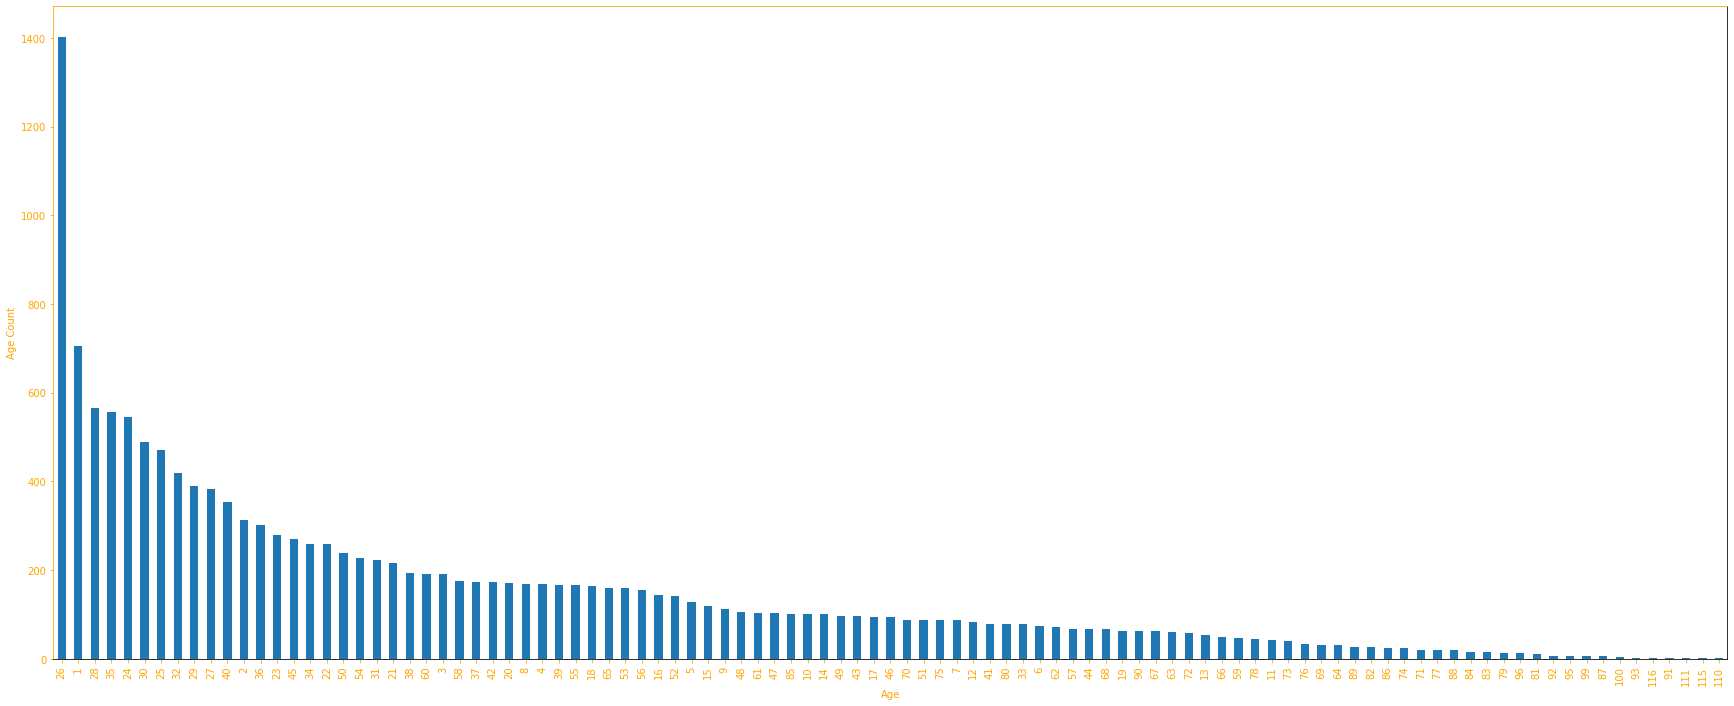

In [52]:
# load the datasets using the csv files train, val and test 
# (3)
dfTrain = pd.read_csv('./data/train.csv')
dfVal = pd.read_csv('./data/val.csv')
dfTest = pd.read_csv('./data/test.csv')

# print the shapes of the dataframes 
# (3)
print(f"Train Data shape: \n{dfTrain.shape}\n")
print(f"Val Data shape: \n{dfVal.shape}\n")
print(f"Test Data shape: \n{dfTest.shape}\n")
print("_____________________________________________\n")

# print the column names from either one of the dataframes 
# (1)
print(f"Train Data coloumns: \n{dfTrain.columns.values}\n")
print(f"Val Data coloumns: \n{dfVal.columns.values}\n")
print(f"Test Data coloumns: \n{dfTest.columns.values}\n")
print("_____________________________________________\n")

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
print(f"Train Data Gender Distribution:\n{dfTrain['gender'].value_counts()}\n")
print(f"Val Data Gender Distribution:\n{dfVal['gender'].value_counts()}\n")
print(f"Test Data Gender Distribution:\n{dfTest['gender'].value_counts()}\n")
print("_____________________________________________\n")

# print the proportional distribution of ethnicity in all three datasets 
# (3)
print(f"Train Data Ethnicity Distribution:\n{dfTrain['ethnicity'].value_counts()}\n")
print(f"Val Data Ethnicity Distribution:\n{dfVal['ethnicity'].value_counts()}\n")
print(f"Test Data Ethnicity Distribution:\n{dfTest['ethnicity'].value_counts()}\n")
print("_____________________________________________\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
# (2)

graph = dfTrain['age'].value_counts().plot(kind='bar', figsize = (30,12), xlabel = "Age", ylabel = "Age Count")
graph.xaxis.label.set_color('orange')        #setting up X-axis label color to white
graph.yaxis.label.set_color('orange')          #setting up Y-axis label color to white
graph.tick_params(axis='x', colors='orange')    #setting up X-axis tick color to white
graph.tick_params(axis='y', colors='orange')  #setting up Y-axis tick color to white
graph.spines['left'].set_color('orange')        # setting up Y-axis tick color to white
graph.spines['top'].set_color('orange')         #setting up above X-axis tick color to white

#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 4696 validated image filenames.
Found 3757 validated image filenames.


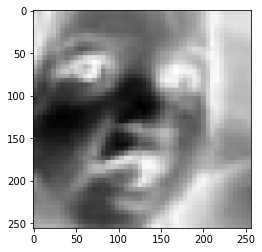

In [53]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    brightness_range=(0.5,1),
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=2

    
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
# TODO

train_img_gen.flow_from_dataframe(
    dfTrain,
    directory=r"./data/images/train/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output'
)

# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of the augmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale = 2
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# TODO
test_img_gen = ImageDataGenerator(
    brightness_range=(0.5,1),
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=2

    
)

test_img_gen.flow_from_dataframe(
    dfTest,
    directory=r"./data/images/test/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output',
    shuffle=False
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# TODO
val_df_flow = val_img_gen.flow_from_dataframe(
    dfVal,
    directory=r"./data/images/val/",
    x_col= "img_name",
    y_col= ["age", "ethnicity", "gender"],
    batch_size=16,
    color_mode='grayscale',
    class_mode='multi_output',
    shuffle=False
)

# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
for i, element in enumerate(val_df_flow):
    plt.imshow(element[0][0],cmap=plt.cm.binary)
    plt.show()    
    break


#### Create the model (44/100)

In [54]:
# specify the model input with the required shape 
# (1)
model_input = keras.Input(shape=(96, 96, 1)) 

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# (10)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(model_input) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age

# (2)

dense_layer = layers.Dense(10, activation="relu")(x) 

#model = keras.Model(inputs=model_input, outputs=dense_layer)


# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task

# (2)
age_output = layers.Dense(10, activation="linear")(dense_layer)

model = keras.Model(inputs=model_input, outputs=age_output)
print(model.summary())
# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# TODO
# (2)
# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# TODO
# (2)

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# TODO
# (2)
# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
# TODO
# (2)

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# TODO
# (3)

# print the model summary
# TODO
# (0.5)

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = []
# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# TODO
# (2)

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# TODO
# (2)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# TODO
# (2)

# Initiallize TensorBoard
# TODO
# (2)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 20, 20, 128)       738

#### Making predictions on test data (14/100)

In [55]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)

4

In [56]:
# generate predictions using the test generator
(2)

# extract the ethnicity predictions
(2)
# print the classification report for predicting ethnicity
(2)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
(2)
# print the classification report for predicting gender
(2)

2

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
